Import the libraries necessary to analize data

In [132]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [133]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            197914 non-null  datetime64[ns]
 1   state                           197914 non-null  object        
 2   city_or_county                  197914 non-null  object        
 3   latitude                        197914 non-null  float64       
 4   longitude                       197914 non-null  float64       
 5   congressional_district          197914 non-null  int64         
 6   avg_age_participants            197914 non-null  float64       
 7   n_participants_child            197914 non-null  int64         
 8   n_participants_teen             197914 non-null  int64         
 9   n_participants_adult            197914 non-null  int64         
 10  n_males                         197914 non-null  int64  

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [134]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'total_votes_for_state']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'total_votes_for_state',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [135]:
numeric_attributes = [item for item in df.columns if item not in column_to_drop]

In [136]:
#df.boxplot(numeric_attributes, figsize=(30,10))


In [137]:
df.columns

Index(['date', 'state', 'city_or_county', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants',
       'n_participants_child', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'incident_characteristics1',
       'povertyPercentage', 'party', 'candidatevotes', 'totalvotes',
       'total_votes_for_state', 'males_percentage', 'females_percentage',
       'child_percentage', 'teen_percentage', 'adult_percentage',
       'killed_percentage', 'injured_percentage',
       'killed_percentage_per_incident', 'unharmed_percentage',
       'winning_party_percentage', 'arrest_percentage',
       'killed_rate_state_year', 'injured_rate_state_year',
       'arrested_rate_state_year', 'unharmed_rate_state_year'],
      dtype='object')

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            197914 non-null  datetime64[ns]
 1   state                           197914 non-null  object        
 2   city_or_county                  197914 non-null  object        
 3   latitude                        197914 non-null  float64       
 4   longitude                       197914 non-null  float64       
 5   congressional_district          197914 non-null  int64         
 6   avg_age_participants            197914 non-null  float64       
 7   n_participants_child            197914 non-null  int64         
 8   n_participants_teen             197914 non-null  int64         
 9   n_participants_adult            197914 non-null  int64         
 10  n_males                         197914 non-null  int64  

In [139]:
""" attr_to_log = ['avg_age_participants', 'povertyPercentage']
df[attr_to_log] = np.log(df[attr_to_log].values)
df[attr_to_log] = df[attr_to_log].replace(-np.inf, 0)
df[attr_to_log] = df[attr_to_log].fillna(value=0)  """

" attr_to_log = ['avg_age_participants', 'povertyPercentage']\ndf[attr_to_log] = np.log(df[attr_to_log].values)\ndf[attr_to_log] = df[attr_to_log].replace(-np.inf, 0)\ndf[attr_to_log] = df[attr_to_log].fillna(value=0)  "

In [140]:
df[numeric_attributes].describe()

,avg_age_participants,povertyPercentage,males_percentage,females_percentage,child_percentage,teen_percentage,adult_percentage,killed_percentage,injured_percentage,killed_percentage_per_incident,unharmed_percentage,winning_party_percentage,arrest_percentage,killed_rate_state_year,injured_rate_state_year,arrested_rate_state_year,unharmed_rate_state_year
count,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000
mean,26.675314,12.612205,0.148175,0.058712,0.009863,0.082202,0.690598,0.214553,0.326844,0.164287,1.000000,0.681462,0.254175,0.046745,0.050167,0.045157,0.048941
std,13.959938,2.712283,0.291783,0.209104,0.092274,0.271360,0.408597,0.399548,0.437864,0.328837,2.219499,0.130646,0.394619,0.048984,0.049477,0.059325,0.056206
min,0.000000,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,10.800000,0.001842,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.596987,0.000000,0.000000,0.015385,0.010309,0.000000
50%,28.000000,12.400000,0.011173,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.667020,0.000000,0.034483,0.037037,0.030303,0.032258
75%,31.000000,14.100000,0.107143,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.917127,0.749687,0.500000,0.071429,0.070588,0.061856,0.074074
max,101.000000,20.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,31.750000,1.000000,10.000000,0.428571,0.500000,1.000000,0.480000


In [141]:
df_numeric = df.drop(columns=column_to_drop)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   avg_age_participants            197914 non-null  float64
 1   povertyPercentage               197914 non-null  float64
 2   males_percentage                197914 non-null  float64
 3   females_percentage              197914 non-null  float64
 4   child_percentage                197914 non-null  float64
 5   teen_percentage                 197914 non-null  float64
 6   adult_percentage                197914 non-null  float64
 7   killed_percentage               197914 non-null  float64
 8   injured_percentage              197914 non-null  float64
 9   killed_percentage_per_incident  197914 non-null  float64
 10  unharmed_percentage             197914 non-null  float64
 11  winning_party_percentage        197914 non-null  float64
 12  arrest_percentag

## Normalization

A good practice is to scale data to avoid that some features dominates the others in the clustering, so we done it

In [142]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_numeric.values)
scaled_df = pd.DataFrame(X, columns=df_numeric.columns)

In [143]:
scaled_df.tail()

,avg_age_participants,povertyPercentage,males_percentage,females_percentage,child_percentage,teen_percentage,adult_percentage,killed_percentage,injured_percentage,killed_percentage_per_incident,unharmed_percentage,winning_party_percentage,arrest_percentage,killed_rate_state_year,injured_rate_state_year,arrested_rate_state_year,unharmed_rate_state_year
197909,0.267327,0.389610,0.110687,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.754270,0.100000,0.315315,0.153846,0.326923,0.289352
197910,0.326733,0.363636,0.481481,0.600000,0.0,0.0,1.0,0.0,0.0,0.000000,0.171174,0.638471,0.096875,0.000000,0.051282,0.338983,0.181159
197911,0.198020,0.415584,0.028192,0.219512,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.801124,0.100000,0.212121,0.035714,0.361905,0.000000
197912,0.198020,0.480519,1.000000,1.000000,0.0,1.0,1.0,1.0,1.0,0.161905,0.000000,0.620237,0.002857,1.000000,0.688525,0.034483,0.231481
197913,0.257426,0.285714,0.107527,0.081081,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.818208,0.100000,0.000000,0.000000,0.503937,0.000000


## Saving the normalized dataset

In [144]:
scaled_df[column_to_drop] = df[column_to_drop]

In [145]:
scaled_df.to_csv('df_scaled.csv', index=False)

## PCA

In [146]:
pca = PCA(n_components=2)

In [147]:
scaled_df[['pc1','pc2']] = pca.fit_transform(scaled_df[numeric_attributes])

In [148]:
components = pca.components_

In [149]:
df = pd.DataFrame(components, columns=numeric_attributes)

In [150]:
df

,avg_age_participants,povertyPercentage,males_percentage,females_percentage,child_percentage,teen_percentage,adult_percentage,killed_percentage,injured_percentage,killed_percentage_per_incident,unharmed_percentage,winning_party_percentage,arrest_percentage,killed_rate_state_year,injured_rate_state_year,arrested_rate_state_year,unharmed_rate_state_year
0,0.016628,0.013174,0.075392,0.036375,-0.001214,-0.035022,0.013442,0.601361,-0.774694,0.159639,-0.008299,-0.001601,0.009364,0.050465,-0.033453,0.004857,-0.003975
1,0.170448,0.036997,0.276458,0.122183,0.001271,-0.087998,0.793551,0.344249,0.338857,0.071541,0.010950,-0.029098,0.007041,0.015720,-0.024617,-0.001228,-0.020786


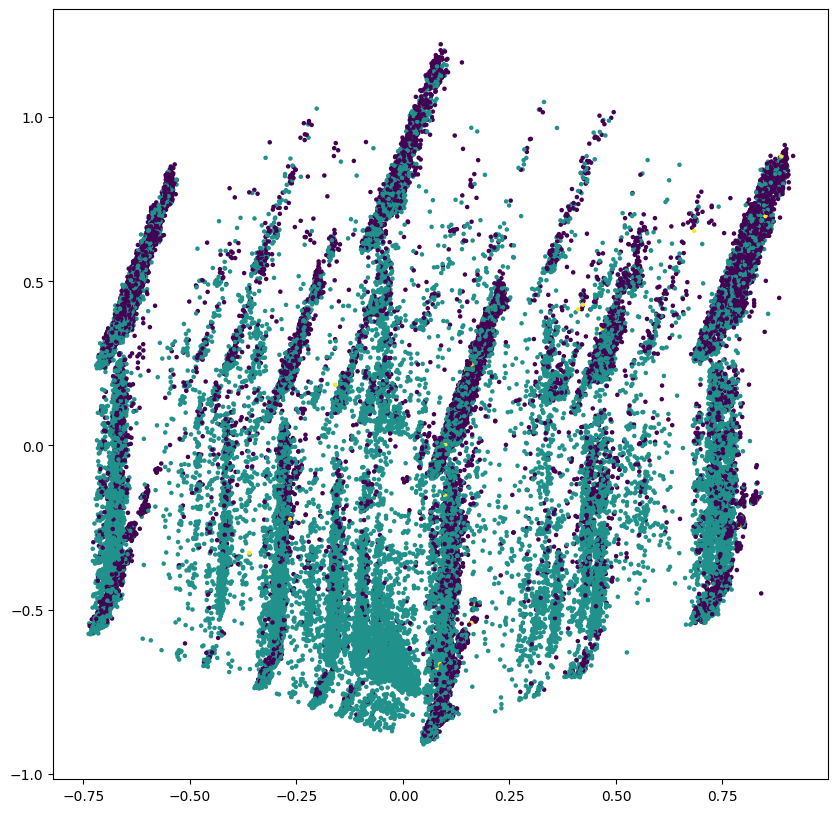

In [151]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique()))))), s=5) 
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()

# create a new legend with the state names and colors
#plt.legend(handles, scaled_df['state'].unique())

# display the plot
plt.show()

In [152]:
""" color_scale = [(0, 'yellow'), (0.02, 'orange'), (0.15,'red'), (1, 'purple')]
fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="state", 
                        hover_data=["city_or_county", "incident_characteristics1"],
                        color="n_killed",
                        color_continuous_scale=color_scale,
                        size="n_participants",
                        zoom=3, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show() """

' color_scale = [(0, \'yellow\'), (0.02, \'orange\'), (0.15,\'red\'), (1, \'purple\')]\nfig = px.scatter_mapbox(df, \n                        lat="latitude", \n                        lon="longitude", \n                        hover_name="state", \n                        hover_data=["city_or_county", "incident_characteristics1"],\n                        color="n_killed",\n                        color_continuous_scale=color_scale,\n                        size="n_participants",\n                        zoom=3, \n                        height=800,\n                        width=800)\n\nfig.update_layout(mapbox_style="open-street-map")\nfig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})\nfig.show() '